In [817]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [818]:
warnings.filterwarnings('ignore')

### Имеется датасет с данными о 333 пингвинах. По каждому пингвину известно: 
- species - информация о виде пингвина;
- island - название острова в архипелаге Палмера;
- bill_length_mm - длина клюва в мм;
- bill_depth_mm - толщина клюва в мм;
- flipper_length_mm - длина крыла в мм;
- body_mass_g - масса тела в граммах;
- sex - пол особи.


Необходимо на основе этих данных построить ряд классификаторов и проверить их работу.


# Задание 1 (в классе). Предварительное исследование данных

### 1. Загрузить данные из файла «pinguins.csv». Проверить, что загружены все 333 кортежа данных по всем 7 признакам


In [819]:
df = pd.read_csv("penguins.csv")
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,male
1,Adelie,Torgersen,39.5,17.4,186,3800,female
2,Adelie,Torgersen,40.3,18.0,195,3250,female
3,Adelie,Torgersen,36.7,19.3,193,3450,female
4,Adelie,Torgersen,39.3,20.6,190,3650,male


In [820]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    int64  
 5   body_mass_g        333 non-null    int64  
 6   sex                333 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 18.3+ KB


### 2. Определить типы данных

In [821]:
df.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm      int64
body_mass_g            int64
sex                   object
dtype: object

### 3. Определить параметры числовых данных


In [822]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


### 4. Для нечисловых (текстовых) данных определить количество записей по каждому элементу и визуализировать гистограммы, например, так (для признака «species»)

In [823]:
df_obj = df.select_dtypes(include=['object']).copy()
df_obj.head()

,species,island,sex
0,Adelie,Torgersen,male
1,Adelie,Torgersen,female
2,Adelie,Torgersen,female
3,Adelie,Torgersen,female
4,Adelie,Torgersen,male


species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64
island
Biscoe       163
Dream        123
Torgersen     47
Name: count, dtype: int64
sex
male      168
female    165
Name: count, dtype: int64


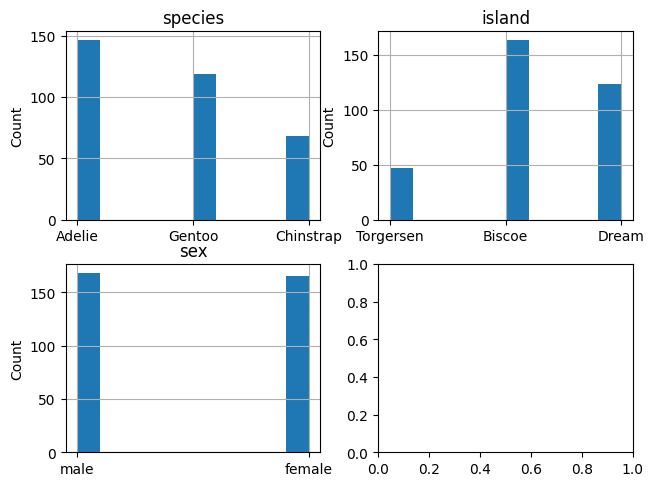

In [824]:
fig, ax = plt.subplots(2,2)
ax = (i for i in ax.flatten())
plt.tight_layout()
for i, col in enumerate(df_obj.columns):
    print(df_obj[col].value_counts())
    cur_ax = next(ax)
    cur_ax.hist(df_obj[col])
    cur_ax.grid(1)
    cur_ax.set_title(col)
    cur_ax.set_ylabel("Count")
    
    

### 5. Для каждого текстового признака построить мозаику 2D диаграмм рассеяния выбирая в качестве параметров всевозможные пары числовых признаков, аналогично мозаике диаграмм для ирисов.


На основе полученных результатов сделать предварительную оценку качества классификации пингвинов по каждому из трёх текстовых признаков на основе только числовых признаков. 


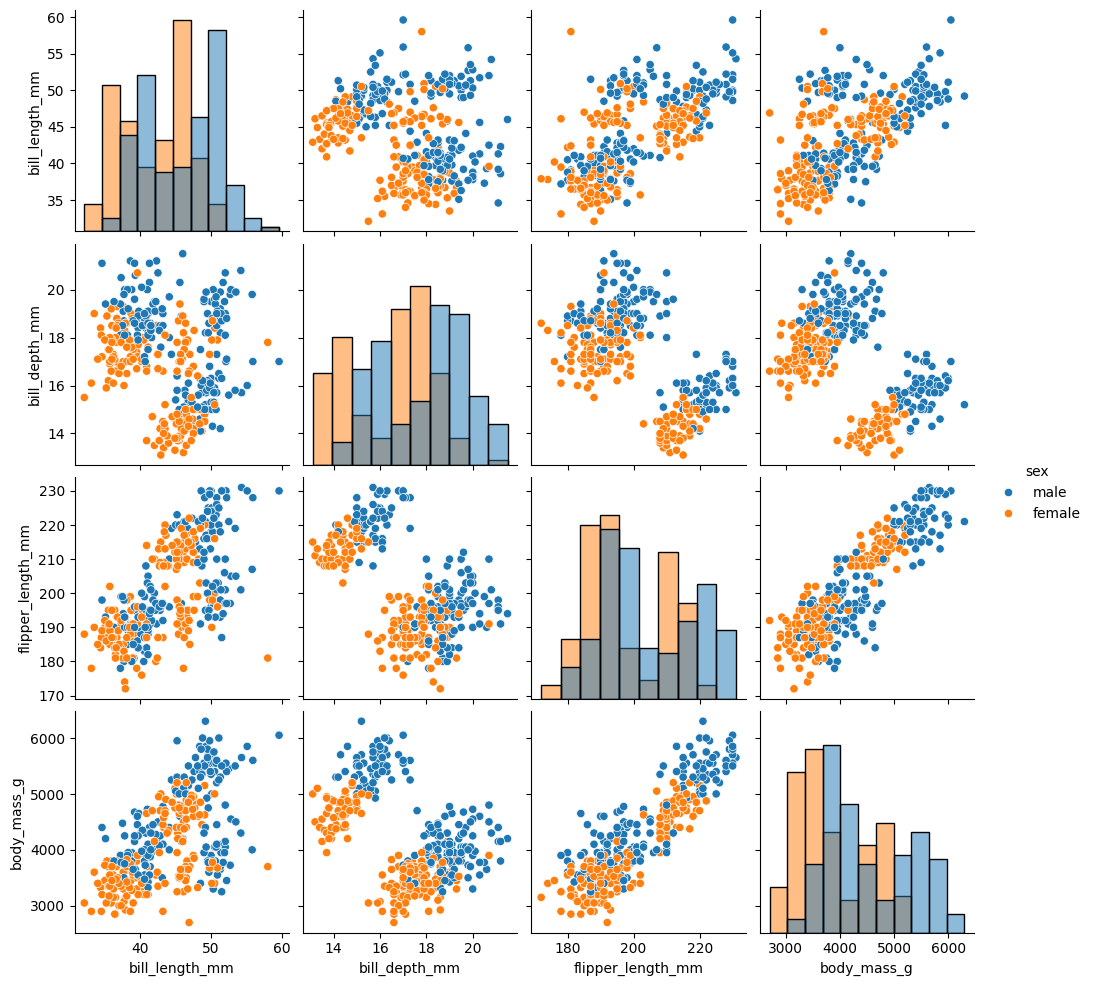

In [825]:
sns.pairplot(df, hue="sex", diag_kind="hist")
plt.show()

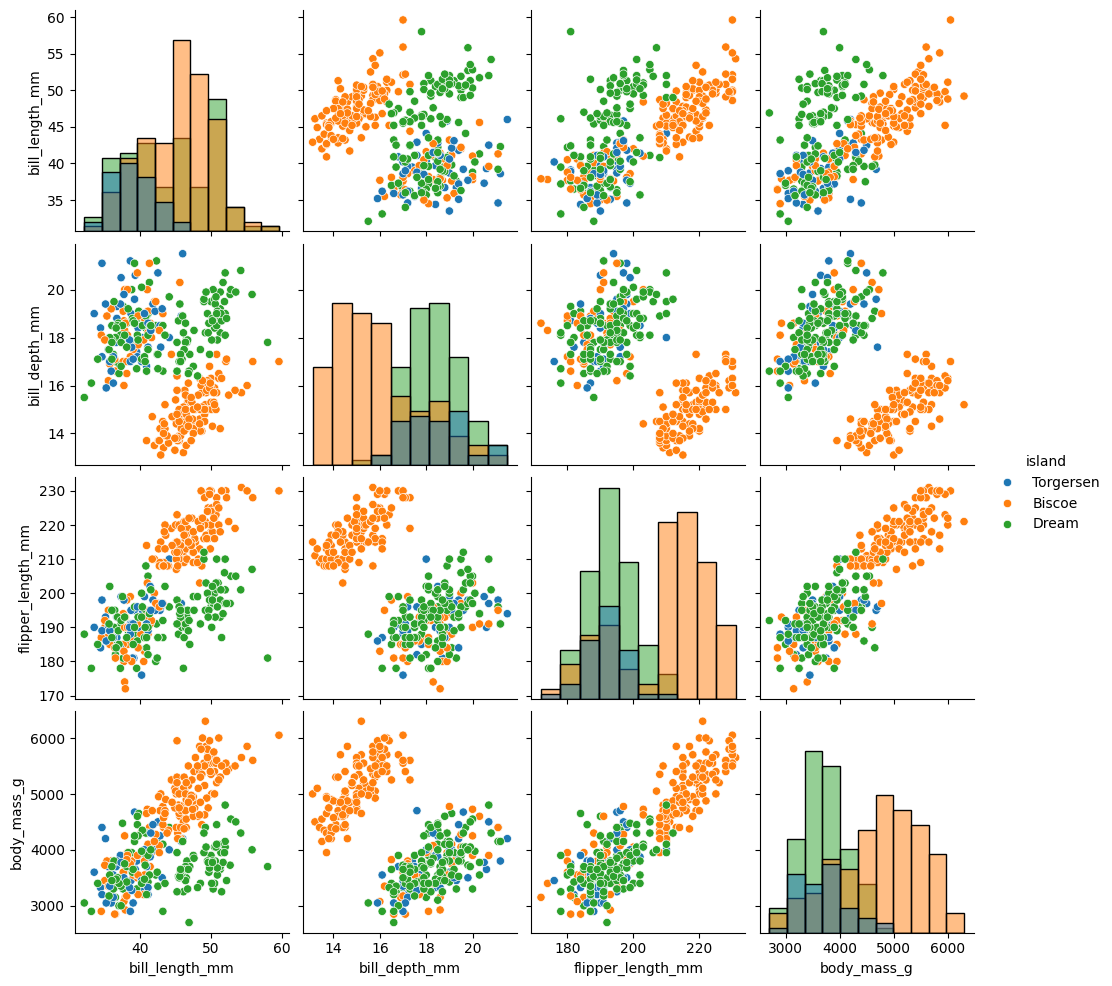

In [826]:
sns.pairplot(df, hue="island", diag_kind="hist")
plt.show()

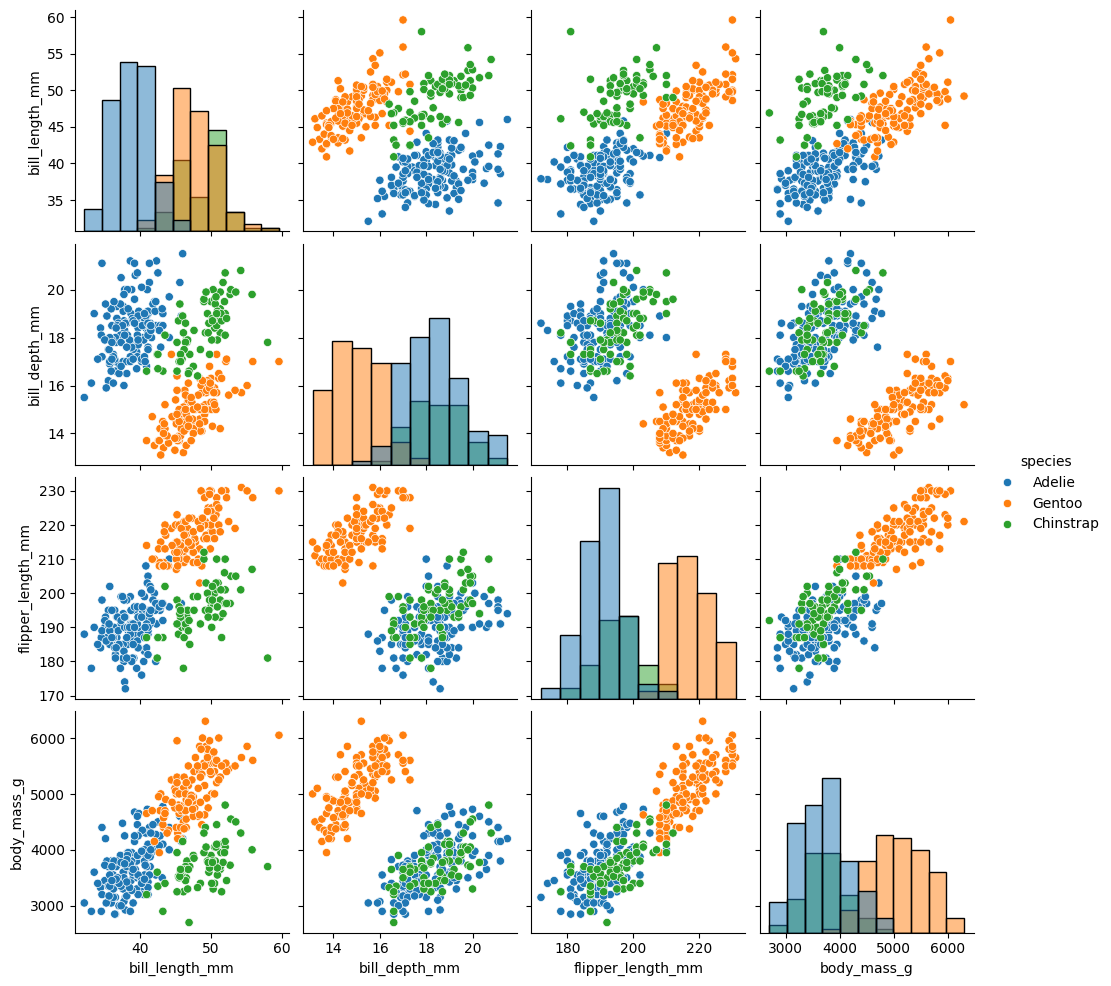

In [827]:
sns.pairplot(df, hue="species", diag_kind="hist")
plt.show()

Линейно разделим признак species, остальные неразделимы

## Стандартизация

Числовые признаки раз

In [828]:
nenorm = df.copy()
numeric = nenorm.select_dtypes(exclude="object")
args = numeric.agg(("mean", "std"))
norm = (numeric - args.loc["mean"]) / args.loc["std"]
df[list(norm.columns.values)] = norm
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,-0.894695,0.779559,-1.424608,-0.567621,male
1,Adelie,Torgersen,-0.821552,0.119404,-1.067867,-0.505525,female
2,Adelie,Torgersen,-0.675264,0.424091,-0.425733,-1.188572,female
3,Adelie,Torgersen,-1.333559,1.084246,-0.568429,-0.940192,female
4,Adelie,Torgersen,-0.858123,1.744400,-0.782474,-0.691811,male
...,...,...,...,...,...,...,...
328,Chinstrap,Dream,2.159064,1.338151,0.430446,-0.257145,male
329,Chinstrap,Dream,-0.090112,0.474872,0.073705,-1.002287,female
330,Chinstrap,Dream,1.025333,0.525653,-0.568429,-0.536573,male
331,Chinstrap,Dream,1.244765,0.931902,0.644491,-0.132954,male


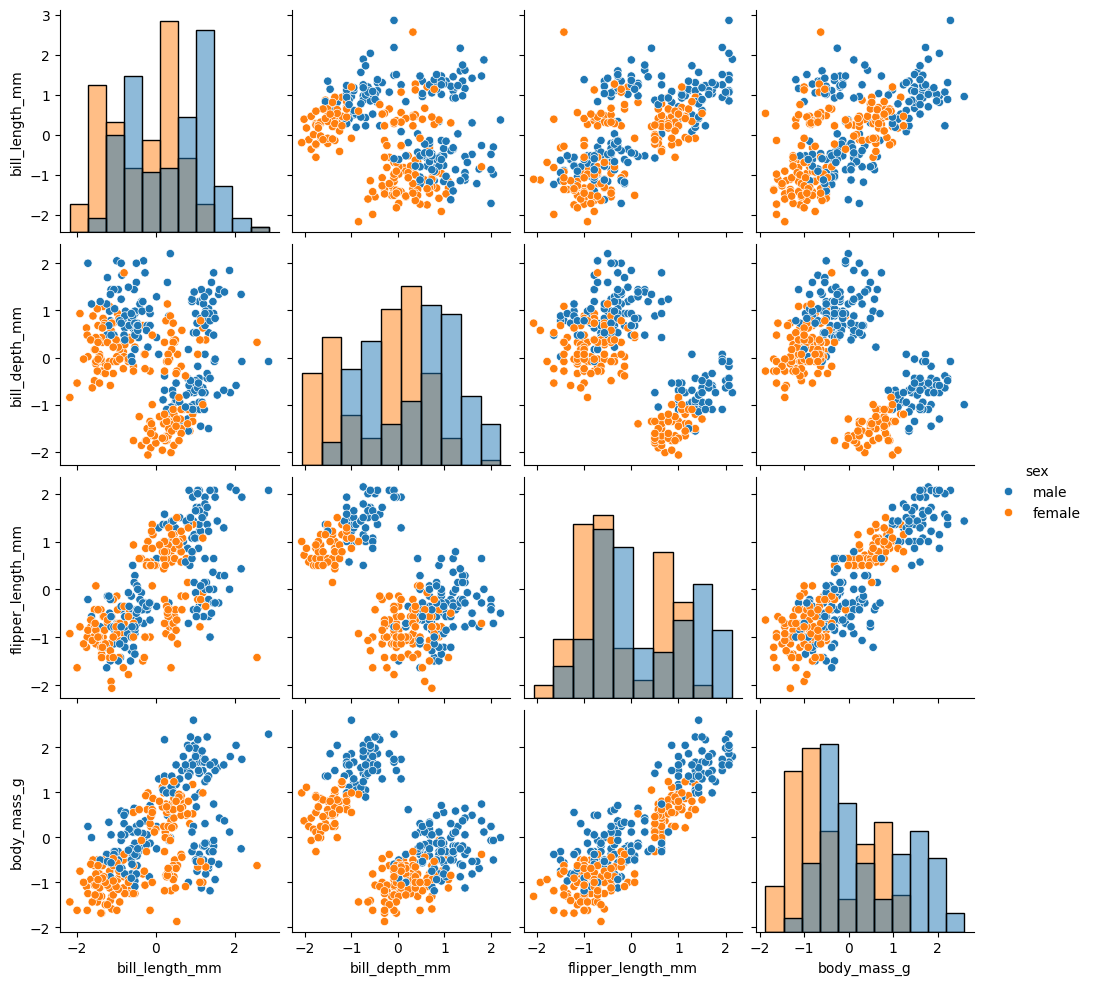

In [829]:
sns.pairplot(df, hue="sex", diag_kind="hist")
plt.show()

# Задание 2. Бинарная классификация персептроном

        Замечание 1: Все классификаторы оформить в виде объектов некоторого написанного вами класса с обязательными конструктором, методами fit() и predict().
        Замечание 2: Для оценку качества работы классификатора использовать метрику качества Accuracy (точность) – доля объектов тестовой выборки, класс которых был распознан правильно.
        Замечание 3: оценку качества работы классификатора выполнять в 2-х вариантах. Сначала используя всю выборку как обучающую и как тестовую (одна оценка accuracy), а потом с разделением исходной выборки на 2 части: 70% - обучающая выборка (по ней будет обучаться классификатор) и 30% - тестовая выборка (объекты этой группы не будут использованы для обучения классификатора). Точность классификации показывать на обеих выборках – обучающей и тестовой. Объяснять различие полученных значений.



In [830]:
class Perceptron:
    def __init__(self, N: int = 4, b: int = 1, eta: float = 1):
        self.N = N
        self.W = pd.Series(np.zeros(N))
        self.b = b
        self.eta = eta
        self.accuracy = []
        self.errors =[]
    
    def activation(self, Y: pd.Series):
        return Y >= 0
    
    def fit(self, X: pd.DataFrame, Y: pd.Series, epoch=100) -> None:
        data = X.copy()
        data["Y"] = Y
        for _ in range(epoch):
            sample = data.sample(frac=1)
            Y = sample["Y"]
            X = sample.drop(columns="Y")
            errors = 0
            for xi, target in zip(X.values,Y.values):
                pred=self.predict(xi)
                update = self.eta * (target - pred)
                self.b += update
                self.W += update * xi
                errors += int(update != 0)
            self.errors.append(errors)
            self.accuracy.append(self.accuracy_pred(X,Y)[0])
    
    
    
            
    def predict(self, X: pd.DataFrame) -> pd.Series:
        result = np.dot(X, self.W) + self.b
        return self.activation(result)
    
    def accuracy_pred(self, X: pd.DataFrame, Y: pd.Series) -> dict[str:float, str:pd.Series]:
        pred = self.predict(X)
        acc = np.mean(pred == Y)
        return acc, pred

In [831]:
class Perceptron_ada:
    def __init__(self, N: int = 4, b: int = 1, eta: float = 1e-1):
        self.N = N
        self.W = pd.Series(np.zeros(N))
        self.b = b
        self.eta = eta
        self.accuracy = []
    
    
    def activation(self, Y: pd.Series):
        return Y >= 0
    
    def fit(self, X: pd.DataFrame, Y: pd.Series, epoch=100) -> None:
        data = X.copy()
        data["Y"] = Y
        for _ in range(epoch):
            sample = data.sample(frac=1)
            Y = sample["Y"]
            X = sample.drop(columns="Y")
            acc, pred = self.accuracy_pred(X, Y)
            errors = Y - pred
            # self.accuracy.append((errors**2).sum()/errors.shape[0])
            self.accuracy.append(acc)
            self.b += errors.sum() * self.eta
            self.W += np.dot(errors,X) * self.eta
            
            
    def predict(self, X: pd.DataFrame) -> pd.Series:
        result = np.dot(X, self.W) + self.b
        return self.activation(result)
    
    def accuracy_pred(self, X: pd.DataFrame, Y: pd.Series) -> dict[str:float, str:pd.Series]:
        pred = self.predict(X)
        acc = np.mean(pred == Y)
        return acc, pred

### 1. Используя персептрон, постройте бинарный классификатор для определения пола пингвина на основе только числовых признаков. Оцените качество работы классификатора.



In [832]:
df['sex'].replace('male', True, inplace=True)
df['sex'].replace('female', False, inplace=True)
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,-0.894695,0.779559,-1.424608,-0.567621,True
1,Adelie,Torgersen,-0.821552,0.119404,-1.067867,-0.505525,False
2,Adelie,Torgersen,-0.675264,0.424091,-0.425733,-1.188572,False
3,Adelie,Torgersen,-1.333559,1.084246,-0.568429,-0.940192,False
4,Adelie,Torgersen,-0.858123,1.744400,-0.782474,-0.691811,True


In [833]:
df_num = df.select_dtypes(exclude=['object', 'bool'])
df_num.info()
Y = df['sex'].astype('int64')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bill_length_mm     333 non-null    float64
 1   bill_depth_mm      333 non-null    float64
 2   flipper_length_mm  333 non-null    float64
 3   body_mass_g        333 non-null    float64
dtypes: float64(4)
memory usage: 10.5 KB


In [834]:
model_all = Perceptron(eta=1)
# model_all = Perceptron(eta=1)
# model_all = Perceptron(eta=1e-26)
# model_all = Perceptron(eta=1e-27)
model_all.fit(df_num, Y, epoch=100)
model_all.W,model_all.b

(0    0.380052
 1    5.887866
 2    1.205849
 3    4.807619
 dtype: float64,
 np.int64(-2))

In [835]:
res1, *_ = model_all.accuracy_pred(df_num, Y)
print(f'accuracy: {res1}, max: {max(model_all.accuracy)}')

accuracy: 0.8528528528528528, max: 0.9069069069069069


<Axes: >

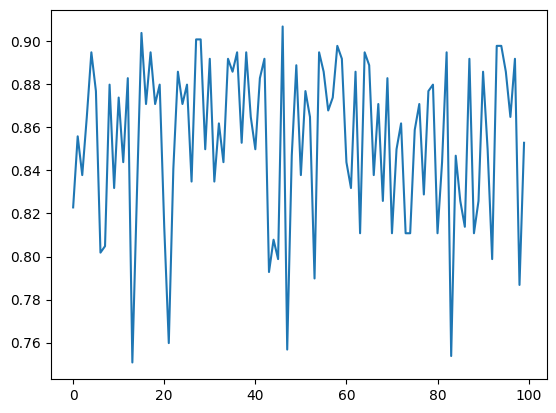

In [836]:
sns.lineplot(model_all.accuracy)

In [837]:
X = df_num
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)
model_train  = Perceptron(eta=1)
model_train.fit(X_train, y_train,
                epoch=100
                )
train = model_train.accuracy_pred(X_train, y_train)
test = model_train.accuracy_pred(X_test, y_test)
print("Partial accuracy: ")
print("train: ", train[0]) 
print("test: ", test[0]) 

Partial accuracy: 
train:  0.8326180257510729
test:  0.77


### 2. Постройте 3 классификатора для определения пола пингвина на основе числовых признаков для каждого из видов пингвинов. Оцените их качество. Сравните точности классификаторов между собой и с классификатором п.2.1.



In [838]:
df.species.unique()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

In [839]:
models: dict[list[Perceptron]] = {}
for species in df.species.unique():
    print(f"Species: {species}")
    df_tmp = df[df['species'] == species]
    y = df_tmp['sex'].astype('int64')
    X = df_tmp.select_dtypes(exclude=['object', 'bool'])
    model_tmp = Perceptron()
    model_tmp.fit(X,y, 
                  epoch=100
                  )
    # print(model_tmp.W, model_tmp.b)
    res = model_tmp.accuracy_pred(X, y)
    print("Full accuracy: ", res[0]) 
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
    model_train  = Perceptron()
    model_train.fit(X_train, y_train,
                    epoch=100
                    )
    train = model_train.accuracy_pred(X_train, y_train)
    test = model_train.accuracy_pred(X_test, y_test)
    print("Partial accuracy: ")
    print("train: ", train[0]) 
    print("test: ", test[0]) 
    models[species] = [model_tmp, model_train]
    

Species: Adelie
Full accuracy:  0.9041095890410958
Partial accuracy: 
train:  0.9215686274509803
test:  0.7727272727272727
Species: Gentoo
Full accuracy:  0.9495798319327731
Partial accuracy: 
train:  0.9759036144578314
test:  0.9444444444444444
Species: Chinstrap
Full accuracy:  0.8823529411764706
Partial accuracy: 
train:  0.8297872340425532
test:  0.7142857142857143


На некоторых(Adelie) видах лучше получается разделять (лучше accuracy), т.к. признак 'sex' более линейно разделим.  

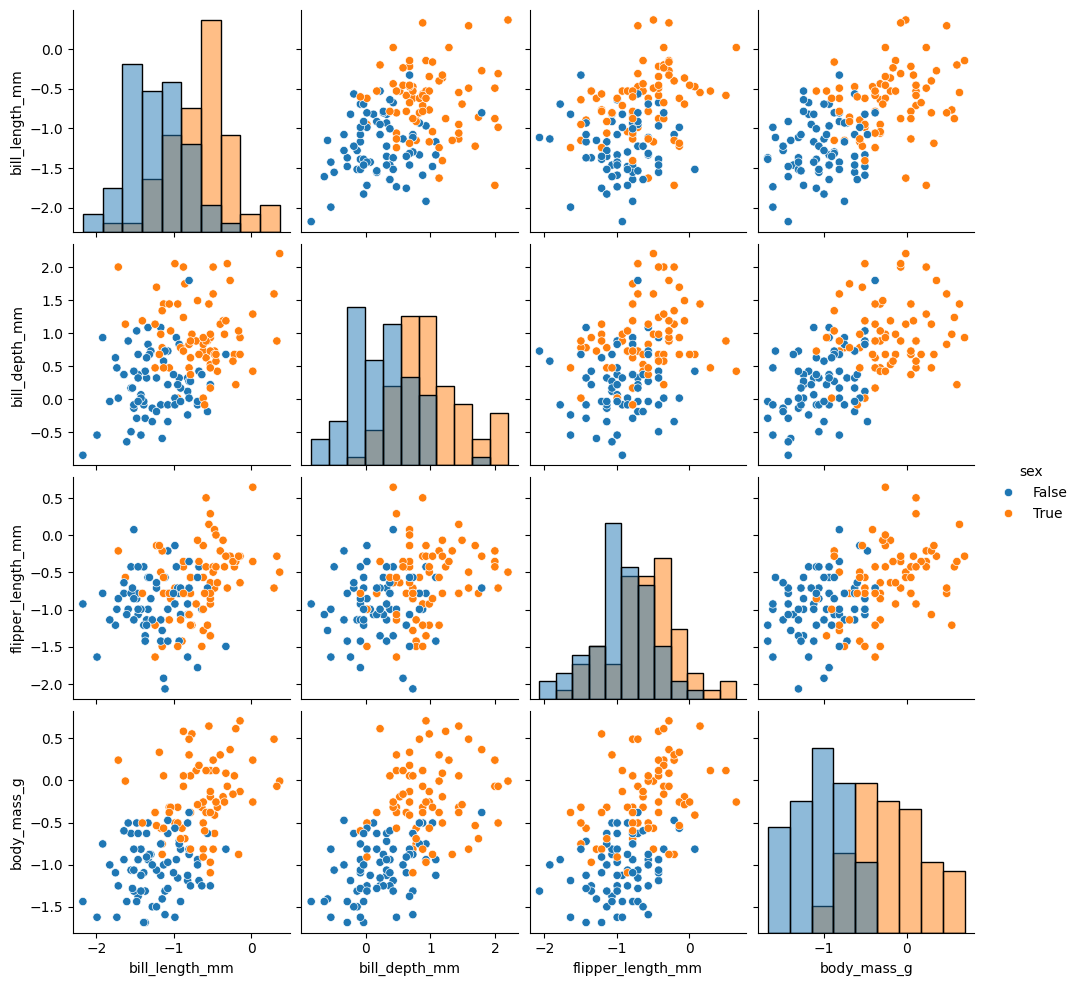

In [840]:
sns.pairplot(df[df['species'] == 'Adelie'], hue="sex", diag_kind="hist")
plt.show()

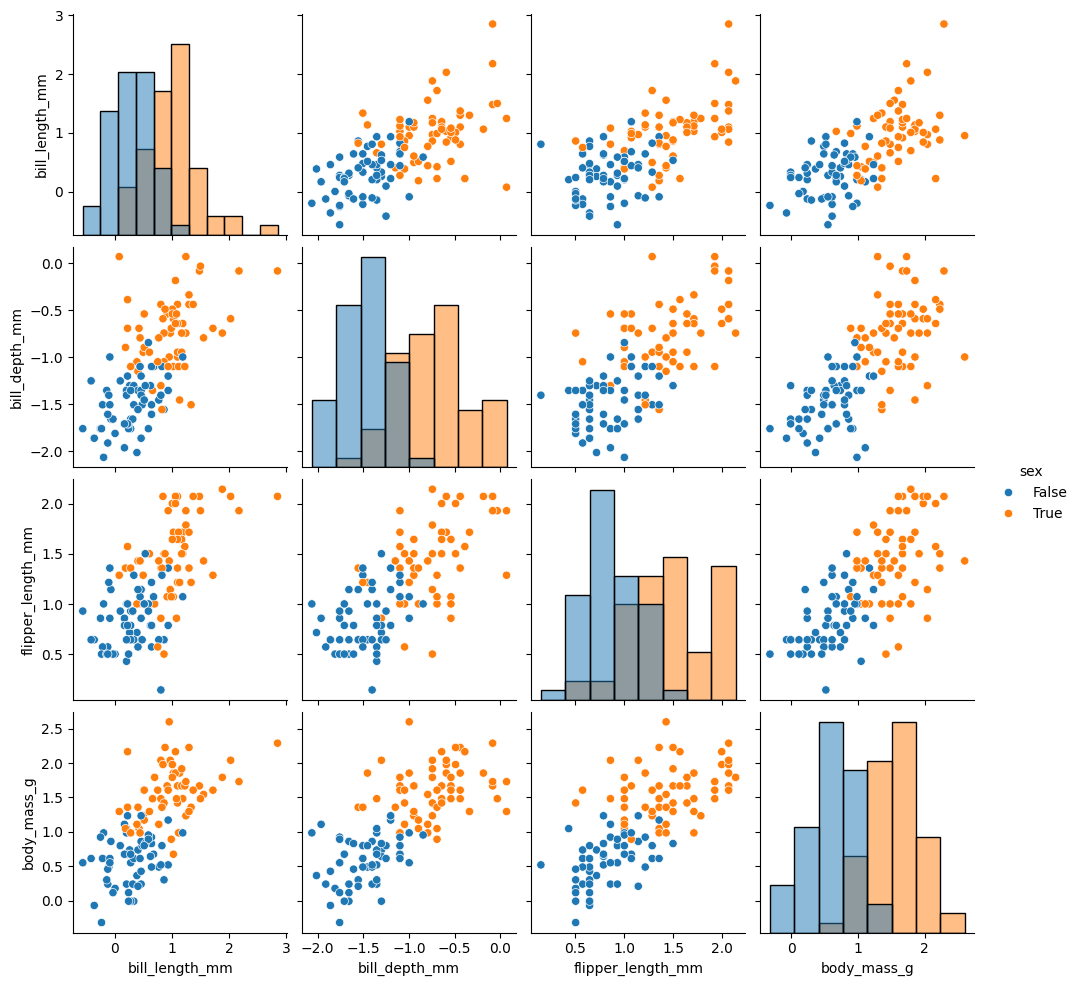

In [841]:
sns.pairplot(df[df['species'] == 'Gentoo'], hue="sex", diag_kind="hist")
plt.show()

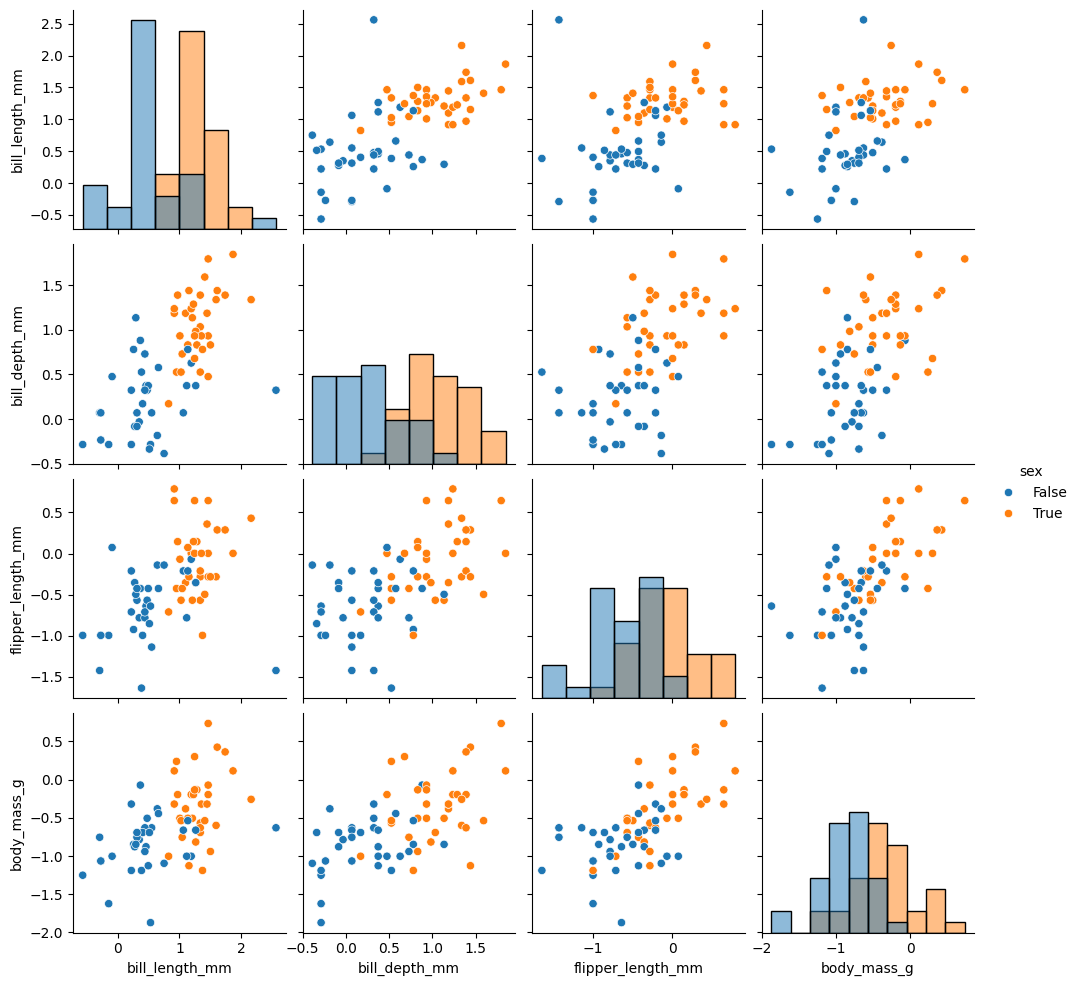

In [842]:
sns.pairplot(df[df['species'] == 'Chinstrap'], hue="sex", diag_kind="hist")
plt.show()

### 3. Попробуйте каждый из 3-х классификаторов п.2.2 проверить на всей выборке (т.е. на пингвинах разных видов).



In [843]:
for key, value in models.items():
    print(f"Species: {key}")
    acc_f, pred_f = value[0].accuracy_pred(df_num, Y)
    acc_p, pred_p = value[1].accuracy_pred(df_num, Y)
    print(f"Full accuracy: {acc_f}")
    print(f"Partial accuracy: {acc_p}")

Species: Adelie
Full accuracy: 0.6936936936936937
Partial accuracy: 0.6996996996996997
Species: Gentoo
Full accuracy: 0.7357357357357357
Partial accuracy: 0.7327327327327328
Species: Chinstrap
Full accuracy: 0.7747747747747747
Partial accuracy: 0.7117117117117117


Получился результат на новых данных хуже,


# Задание 3. Бинарная классификация с использованием ADALINE.



Повторите пп.1-3 предыдущего задания, построив классификатор на основе адаптивного нейрона.


### 1. Используя персептрон, постройте бинарный классификатор для определения пола пингвина на основе только числовых признаков. Оцените качество работы классификатора.



In [844]:
model_all = Perceptron_ada(eta=1e-5)
# model_all = Perceptron(eta=1)
# model_all = Perceptron(eta=1e-26)
# model_all = Perceptron(eta=1e-27)
model_all.fit(df_num, Y, epoch=1000)
model_all.W,model_all.b

(0    0.074288
 1    0.319402
 2    0.069829
 3    0.228999
 dtype: float64,
 np.float64(0.07975999999999168))

In [845]:
res1, *_ = model_all.accuracy_pred(df_num, Y)
print(f'accuracy: {res1}, max: {max(model_all.accuracy)}')

accuracy: 0.8768768768768769, max: 0.8768768768768769


<Axes: >

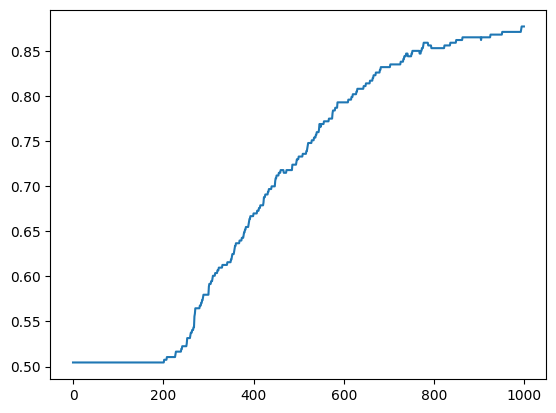

In [846]:
sns.lineplot(model_all.accuracy)

In [847]:
X = df_num
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)
model_train  = Perceptron_ada(eta=1e-5)
model_train.fit(X_train, y_train,
                epoch=1000
                )
train = model_train.accuracy_pred(X_train, y_train)
test = model_train.accuracy_pred(X_test, y_test)
print("Partial accuracy: ")
print("train: ", train[0]) 
print("test: ", test[0]) 

Partial accuracy: 
train:  0.8454935622317596
test:  0.77


### 2. Постройте 3 классификатора для определения пола пингвина на основе числовых признаков для каждого из видов пингвинов. Оцените их качество. Сравните точности классификаторов между собой и с классификатором п.2.1.



In [848]:
df.species.unique()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

In [849]:
models = {}
for species in df.species.unique():
    print(f"Species: {species}")
    df_tmp = df[df['species'] == species]
    y = df_tmp['sex'].astype('int64')
    X = df_tmp.select_dtypes(exclude=['object', 'bool'])
    model_tmp = Perceptron_ada(eta=1e-5)
    model_tmp.fit(X,y, 
                  epoch=1000
                  )
    # print(model_tmp.W, model_tmp.b)
    res = model_tmp.accuracy_pred(X, y)
    print("Full accuracy: ", res[0]) 
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
    model_train  = Perceptron_ada(eta=1e-5)
    model_train.fit(X_train, y_train,
                    epoch=1000
                    )
    train = model_train.accuracy_pred(X_train, y_train)
    test = model_train.accuracy_pred(X_test, y_test)
    print("Partial accuracy: ")
    print("train: ", train[0]) 
    print("test: ", test[0]) 
    models[species] = [model_tmp, model_train]
    

Species: Adelie
Full accuracy:  0.8424657534246576
Partial accuracy: 
train:  0.8725490196078431
test:  0.75
Species: Gentoo
Full accuracy:  0.7394957983193278
Partial accuracy: 
train:  0.6265060240963856
test:  0.6944444444444444
Species: Chinstrap
Full accuracy:  0.5294117647058824
Partial accuracy: 
train:  0.48936170212765956
test:  0.5238095238095238


### 3. Попробуйте каждый из 3-х классификаторов п.2.2 проверить на всей выборке (т.е. на пингвинах разных видов).


In [850]:
for key, value in models.items():
    print(f"Species: {key}")
    acc_f, pred_f = value[0].accuracy_pred(df_num, Y)
    acc_p, pred_p = value[1].accuracy_pred(df_num, Y)
    print(f"Full accuracy: {acc_f}")
    print(f"Partial accuracy: {acc_p}")

Species: Adelie
Full accuracy: 0.6546546546546547
Partial accuracy: 0.6516516516516516
Species: Gentoo
Full accuracy: 0.5855855855855856
Partial accuracy: 0.5525525525525525
Species: Chinstrap
Full accuracy: 0.5135135135135135
Partial accuracy: 0.5045045045045045


### 4. Включите в список признаков вид пингвина, представив его числом (1,2,3) для разных видов. Оцените качество классификации и сравните с результатом пункта 3.1.


In [851]:
df['species'][df['species'] == 'Gentoo'] = 1
df['species'][df['species'] == 'Adelie'] = 2
df['species'][df['species'] == 'Chinstrap'] = 3
df_vid = df.copy()
df_vid['species'] = df['species'].astype('int64')
df_vid = df_vid.select_dtypes(exclude=['object', 'bool'])


In [852]:
X = df_vid
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)
model_train  = Perceptron_ada(eta=1e-5, N=5)
model_train.fit(X_train, y_train,
                epoch=1000
                )
train = model_train.accuracy_pred(X_train, y_train)
test = model_train.accuracy_pred(X_test, y_test)
print("Partial accuracy: ")
print("train: ", train[0]) 
print("test: ", test[0]) 

Partial accuracy: 
train:  0.8755364806866953
test:  0.84


In [853]:
df_vid

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,2,-0.894695,0.779559,-1.424608,-0.567621
1,2,-0.821552,0.119404,-1.067867,-0.505525
2,2,-0.675264,0.424091,-0.425733,-1.188572
3,2,-1.333559,1.084246,-0.568429,-0.940192
4,2,-0.858123,1.744400,-0.782474,-0.691811
...,...,...,...,...,...
328,3,2.159064,1.338151,0.430446,-0.257145
329,3,-0.090112,0.474872,0.073705,-1.002287
330,3,1.025333,0.525653,-0.568429,-0.536573
331,3,1.244765,0.931902,0.644491,-0.132954


In [854]:
X

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,2,-0.894695,0.779559,-1.424608,-0.567621
1,2,-0.821552,0.119404,-1.067867,-0.505525
2,2,-0.675264,0.424091,-0.425733,-1.188572
3,2,-1.333559,1.084246,-0.568429,-0.940192
4,2,-0.858123,1.744400,-0.782474,-0.691811
...,...,...,...,...,...
328,3,2.159064,1.338151,0.430446,-0.257145
329,3,-0.090112,0.474872,0.073705,-1.002287
330,3,1.025333,0.525653,-0.568429,-0.536573
331,3,1.244765,0.931902,0.644491,-0.132954


<Axes: >

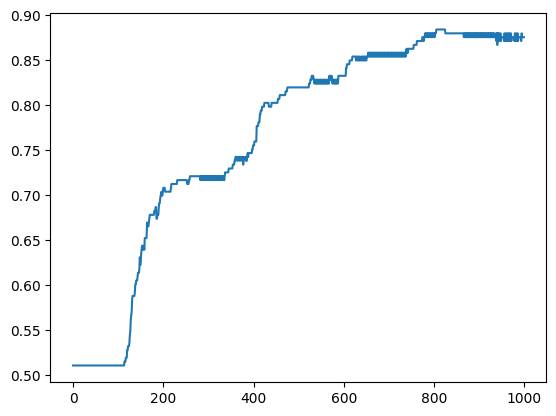

In [855]:
sns.lineplot(model_train.accuracy)

Получилось полная дичь, ожидаемо

### 5. Замените признак вид на три бинарных признака Adelie, Chinstrap, Gentoo, в каждом из которых значение 1 соответствует тому, что данный пингвин принадлежит соответствующему виду: 

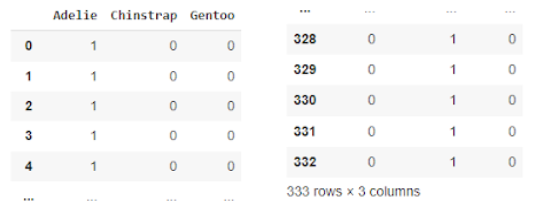

In [856]:
df_vid['Adelie'] = np.where(1==(df['species'] == 1).astype('int64'),1.0,0.0) 
df_vid['Gentoo'] = np.where(1==(df['species'] == 2).astype('int64'),1.0,0.0) 
df_vid['Chinstrap'] = np.where(1==(df['species'] == 3).astype('int64'),1.0,0.0) 


In [857]:
df_vid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    int64  
 1   bill_length_mm     333 non-null    float64
 2   bill_depth_mm      333 non-null    float64
 3   flipper_length_mm  333 non-null    float64
 4   body_mass_g        333 non-null    float64
 5   Adelie             333 non-null    float64
 6   Gentoo             333 non-null    float64
 7   Chinstrap          333 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 20.9 KB


In [858]:
df_vid.drop(columns='species' , inplace=True)

In [859]:
X = df_vid
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)
model_train  = Perceptron_ada(eta=1e-5, N=X.shape[1])
model_train.fit(X_train, y_train,
                epoch=1000
                )
train = model_train.accuracy_pred(X_train, y_train)
test = model_train.accuracy_pred(X_test, y_test)
print("Partial accuracy: ")
print("train: ", train[0]) 
print("test: ", test[0]) 

Partial accuracy: 
train:  0.8841201716738197
test:  0.83


In [860]:
model_train.W

0    0.064815
1    0.260807
2    0.072727
3    0.210159
4   -0.270270
5   -0.207460
6   -0.201720
dtype: float64

<Axes: >

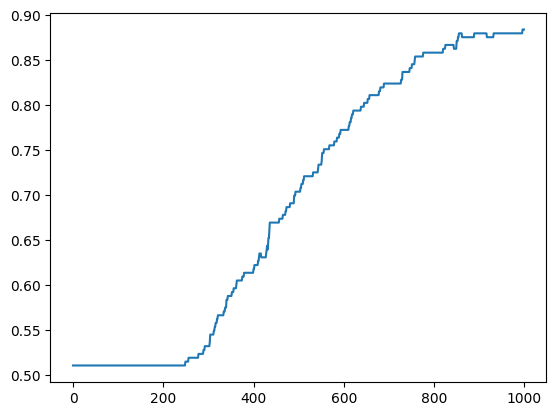

In [861]:
sns.lineplot(model_train.accuracy)

Выполните классификацию по полу, используя уже 7 числовых признаков. Сравните качество классификации с предыдущими вариантами.


Качество немного улучшилось

### 6. Выполните классификацию по каждому из видов пингвина, используя 5 числовых признаков (4 размера-веса и пол: 1-male, 0-female). Сравните качество классификаторов.

In [862]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,2,Torgersen,-0.894695,0.779559,-1.424608,-0.567621,True
1,2,Torgersen,-0.821552,0.119404,-1.067867,-0.505525,False
2,2,Torgersen,-0.675264,0.424091,-0.425733,-1.188572,False
3,2,Torgersen,-1.333559,1.084246,-0.568429,-0.940192,False
4,2,Torgersen,-0.858123,1.744400,-0.782474,-0.691811,True
...,...,...,...,...,...,...,...
328,3,Dream,2.159064,1.338151,0.430446,-0.257145,True
329,3,Dream,-0.090112,0.474872,0.073705,-1.002287,False
330,3,Dream,1.025333,0.525653,-0.568429,-0.536573,True
331,3,Dream,1.244765,0.931902,0.644491,-0.132954,True


In [863]:
df_vid

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,Adelie,Gentoo,Chinstrap
0,-0.894695,0.779559,-1.424608,-0.567621,0.0,1.0,0.0
1,-0.821552,0.119404,-1.067867,-0.505525,0.0,1.0,0.0
2,-0.675264,0.424091,-0.425733,-1.188572,0.0,1.0,0.0
3,-1.333559,1.084246,-0.568429,-0.940192,0.0,1.0,0.0
4,-0.858123,1.744400,-0.782474,-0.691811,0.0,1.0,0.0
...,...,...,...,...,...,...,...
328,2.159064,1.338151,0.430446,-0.257145,0.0,0.0,1.0
329,-0.090112,0.474872,0.073705,-1.002287,0.0,0.0,1.0
330,1.025333,0.525653,-0.568429,-0.536573,0.0,0.0,1.0
331,1.244765,0.931902,0.644491,-0.132954,0.0,0.0,1.0


In [872]:
sps = {1: 'Adelie', 2:'Gentoo', 3: 'Chipstrap'}
X = df_num
X['sex'] = df['sex'].astype("int64")
ans = pd.DataFrame()
ans['species'] = df['species']
for species in df.species.unique():
    print(f"Species: {sps[species]}")
    perc = Perceptron_ada(N=5, eta=1e-5)
    Y = np.where(1==(df['species'] == species).astype('int64'),1.0,0.0) 
    perc.fit(X,Y, epoch=1000)
    acc, pred = perc.accuracy_pred(X,Y)
    print(acc)
    ans[str(species)] = pred 
    
    print("-"*20)
    
    

Species: Gentoo
0.9129129129129129
--------------------
Species: Adelie
0.972972972972973
--------------------
Species: Chipstrap
0.954954954954955
--------------------


### 7. Повторите предыдущий пункт, добавив к 5 числовым признакам ещё три бинарных, представляющих принадлежность к тому или иному острову.


In [873]:
X = df_vid
X['sex'] = df['sex'].astype("int64")
ans = pd.DataFrame()
ans['species'] = df['species']
for species in df.species.unique():
    print(f"Species: {sps[species]}")
    perc = Perceptron_ada(N=8, eta=1e-5)
    Y = np.where(1==(df['species'] == species).astype('int64'),1.0,0.0) 
    perc.fit(X,Y, epoch=1000)
    acc, pred = perc.accuracy_pred(X,Y)
    print(acc)
    ans[str(species)] = pred 
    
    print("-"*20)
    
    

Species: Gentoo
0.96996996996997
--------------------
Species: Adelie
0.978978978978979
--------------------
Species: Chipstrap
0.990990990990991
--------------------


# Задание 4. Множественная классификация с использованием ADALINE.

In [175]:
species = original["species"].unique().tolist()

In [176]:
train, test = train_test_split(original, test_size=0.33, random_state=42)

In [177]:
understand = train.select_dtypes(exclude="object")
understand_test = test.select_dtypes(exclude="object")

In [178]:

middle = [Perceptron_ada() for _ in species]
final = Perceptron_ada(3)

middle_pred = dict()
for per, spec in zip(middle, species):
    per.fit(understand, (train["species"] == spec)*1)
    middle_pred[f"is_{spec}"] = per.predict(understand)


final.fit(pd.DataFrame(middle_pred),
          train["species"].map(species.index))

In [179]:
middle_pred = {spec: perc.predict(understand_test)
               for perc, spec in zip(middle, species)}

final_pred = final.predict(pd.DataFrame(middle_pred))
(final_pred == test['species'].map(species.index)).mean()

0.4727272727272727

Постройте сеть из 4 нейронов. На первом слое три из них определяют принадлежность к одному из трёх видов пингвинов. На втором слое на основе оценок 1-го слоя выносится суждение о том, какому из видов принадлежит конкретный объект. Нейрон этого слоя тоже надо обучить.
Провести расчёты в трёх вариантах: используя 4 числовых слоя (только размеры-веса), используя 5 числовых слоёв (+пол), используя 8 числовых слоёв (+остров).
Оценить качество полученных классификаторов. Сделать вывод.



Оценка за работу 5 баллов.
Дополнительные 2 балла могут быть выставлены, если обучение каждого классификатора сопровождается выводом графика динамики качества обучения по эпохам и диаграммы классификации областей (оси – два числовых признака размер/вес на выбор студента).


Дополнительный 1 балл за вывод перед каждым обучением информации о характере обучения и первых 5-ти строк обучающей выборки.
